# Import

In [9]:
import re
import pandas as pd
import seaborn as sb
import numpy as np
from pandas import DataFrame, Series
import matplotlib.pyplot as mp

from typing import List
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

***I'd like to define some utility functions***

In [10]:
def replace_str(df: DataFrame,  match_str: str, *columns: List[str]) -> DataFrame:
    """
    Remove the `match_str`of each value in `columns` of df
    and convert to float.
    
    Params:
    df -- the dataframe
    columns -- the list of column names need to replace
    
    Return:
    df after replace
    
    Raise:
    ValueError if column contains value that cannot convert to float
    """
    
    for column in columns:
        if (column not in df.columns):
            print(f"[WARN] - The columns `{column}` is not in the given dataframe.")
            continue
            
        try:
            df[column] = df[column].replace(match_str, "", regex=True).astype(float)
        except:
            raise ValueError(f"[ERROR] - The `{column}` column contains invalid data format.")
    
    return df

def convert_currency_to_float(df: DataFrame, *columns: List[str]) -> DataFrame:
    """
    Convert specific columns whose data format is currency with `$` sign to float.
    By removing `$` and `,` from the original data and then convert to float.
    
    Params:
    df -- the dataframe
    columns -- the list of column names need to convert
    
    Return:
    The dataframe with colmuns converted
    
    Raise:
    ValueError if column contains value that cannot convert to float
    """
    return replace_str(df, "[\$,]", *columns)

def convert_percent_to_float(df: DataFrame, *columns: List[str]) -> DataFrame:
    """
    Convert specific columns whose data format is currency with `%` sign to float.

    Params:
    df -- the dataframe
    columns -- the list of column names need to convert

    Return:
    The dataframe with colmuns converted

    Raise:
    ValueError if column contains value that cannot convert to float
    """
    return replace_str(df, "[\%]", *columns)


def explore_missing_value(df: DataFrame):
    """Plot the precent of missing value for each columns"""
    
    missing_data = np.sum(df.isna())/df.shape[0]*100
    missing_data.plot(title="Missing data",
                      kind="bar")

## The dataset files.
***These files are data from Seatle Airbnb dataset***

    1. calendar.csv
    2. listings.csv    

## Questions

    1. What's is the time the house/apartment is cheapest and most available?
    2. How is the price affected by other variables?
    3. Where should we go to get the cheaper price?


## Read data

In [11]:
calendar_df = pd.read_csv("./calendar.csv")
listings_df = pd.read_csv("./listings.csv")

In [12]:
calendar_df.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [13]:
listings_df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


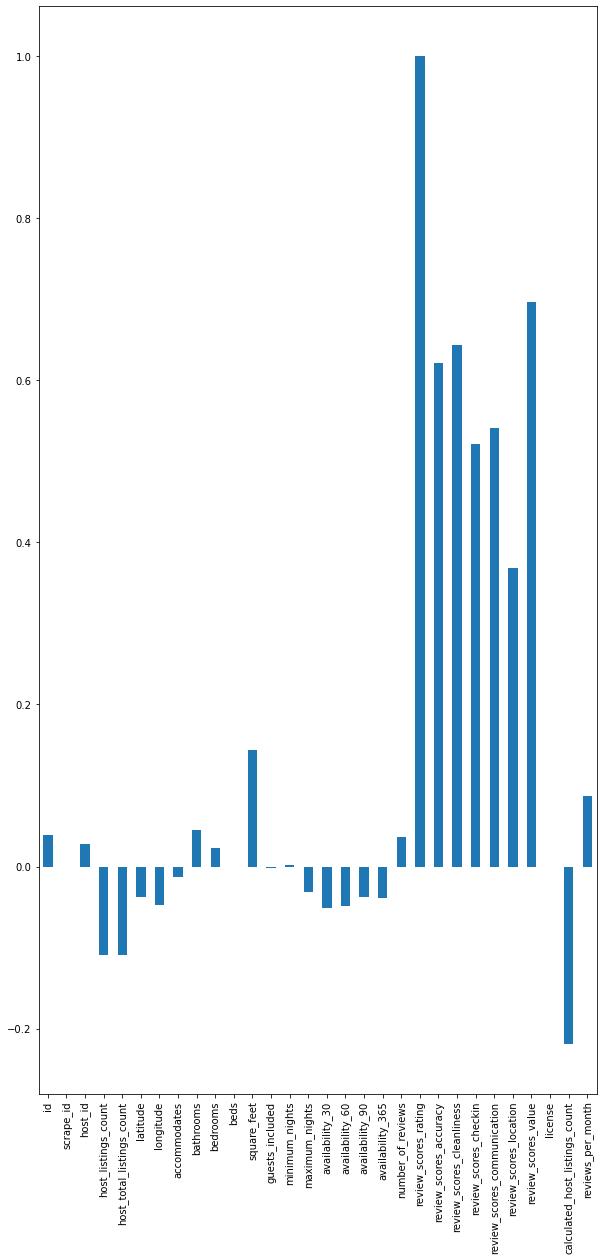

In [14]:
_ = listings_df.corr().review_scores_rating.plot.bar(figsize=(10, 20))

## The calendar data

### Clean data

The current `dtype` of `price` is just string with `$` sign. Let's remove it and covert it to float.

Beside, ther are some thousands-separator `,`, we should remove it too.

In [15]:
calendar_price_converted = convert_currency_to_float(calendar_df, "price")

*Look at the missing value*

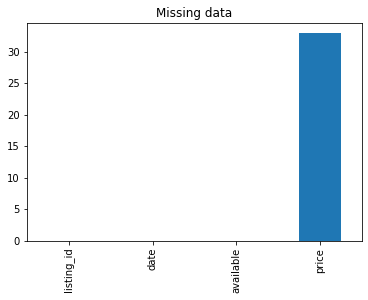

In [16]:
explore_missing_value(calendar_price_converted)

There's about **30%** of missing value in `price`. 
This field is numeric value. I want to use `mean()` to fill all NaN value for it.

In [17]:
def fill_na_mean(df: DataFrame,
                 *columns: List[str]) -> DataFrame:
    """
    Fillna for `columns` of `df`
    
    Param:
    df -- The dataframe
    columns -- List of column name need to fill
    
    Return:
    The dataframe with filled columns
    
    Raise:
    InputError: any column name is not in `df`
    ValueError: cannot calculate mean value of the column
    """
    
    if(any(column not in df.columns for column in columns)):
        raise InputError("Some of given columns is not in `df`")
    
    for column in columns:
        df[column] = df[column].fillna(df[column].mean())
    
    return df

calendar_filled = fill_na_mean(calendar_price_converted, "price")

**Here I have no missing value!**

Covert type of `date` to `Datetime`

In [18]:
calendar_filled.date = pd.to_datetime(calendar_filled.date)

# 1. Question 1 - When should we book a room?

### Generate some variables from `date`

In [19]:
def get_day_name(number: int) -> str:
    day_dict = {
        0: '0_Monday',
        1: '1_Tuesday',
        2: '2_Wednesday',
        3: '3_Thursday',
        4: '4_Friday',
        5: '5_Saturday',
        6: '6_Sunday'
    }
    
    return day_dict[number]
calendar_filled["day_of_week"] = calendar_filled.date.dt.dayofweek
calendar_filled["day_of_week"] = calendar_filled["day_of_week"].apply(lambda x: get_day_name(x))

calendar_filled["month"] = calendar_filled.date.dt.month

In [20]:
calendar_filled.day_of_week

0             0_Monday
1            1_Tuesday
2          2_Wednesday
3           3_Thursday
4             4_Friday
              ...     
1393565     3_Thursday
1393566       4_Friday
1393567     5_Saturday
1393568       6_Sunday
1393569       0_Monday
Name: day_of_week, Length: 1393570, dtype: object

***How is the price in a week?***

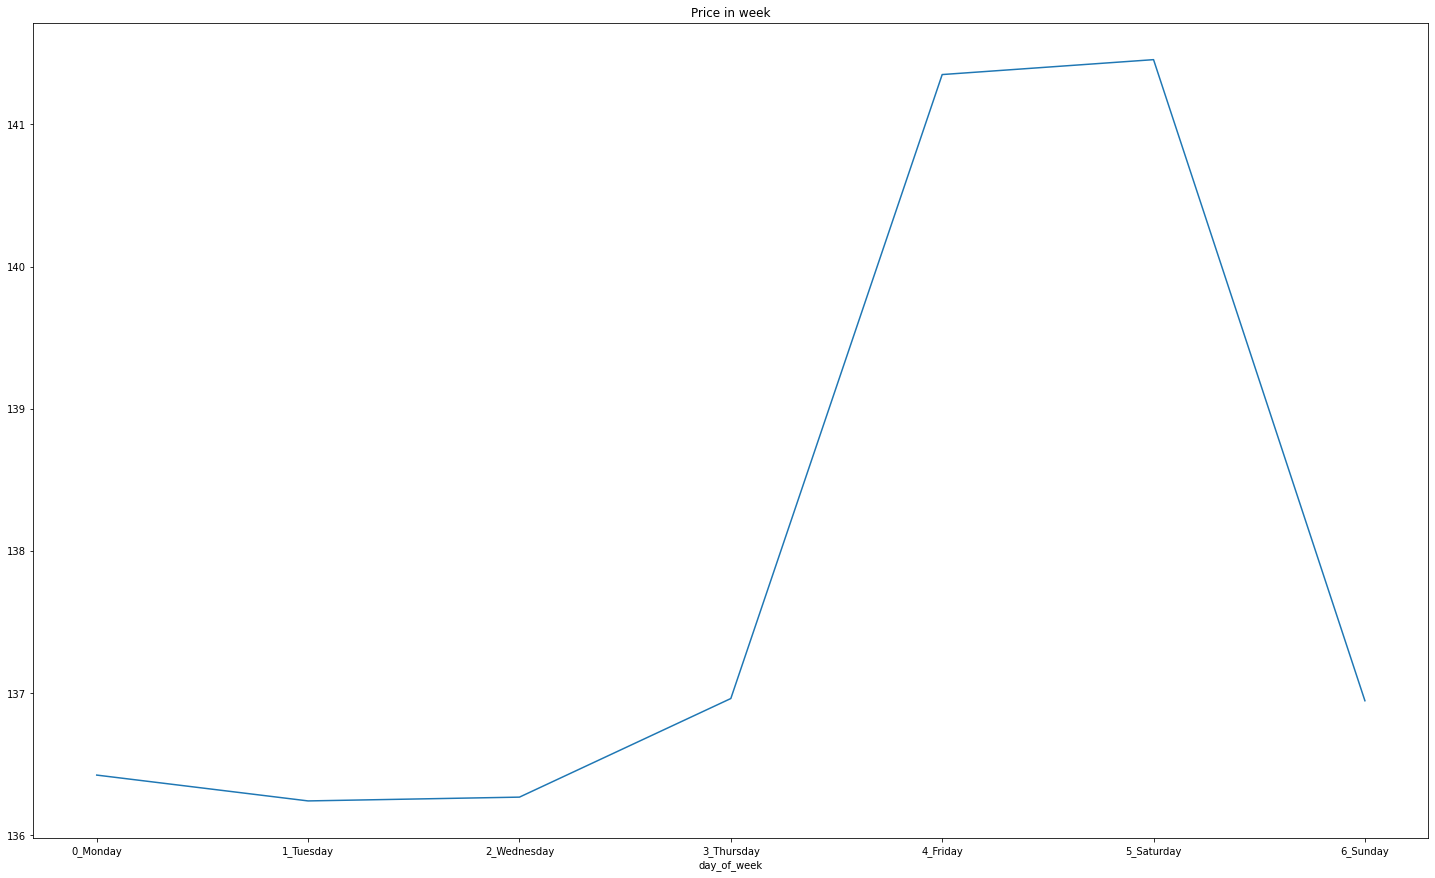

In [62]:
_ = calendar_filled.groupby("day_of_week").price.mean().plot.line(title="Price in week", y="Price", figsize=(25, 15))

***How about the availability in a week?***

First, let's make some conversion in the `availabble` column.
The value `t`, `f` will be converted to 1, 0 respectively.

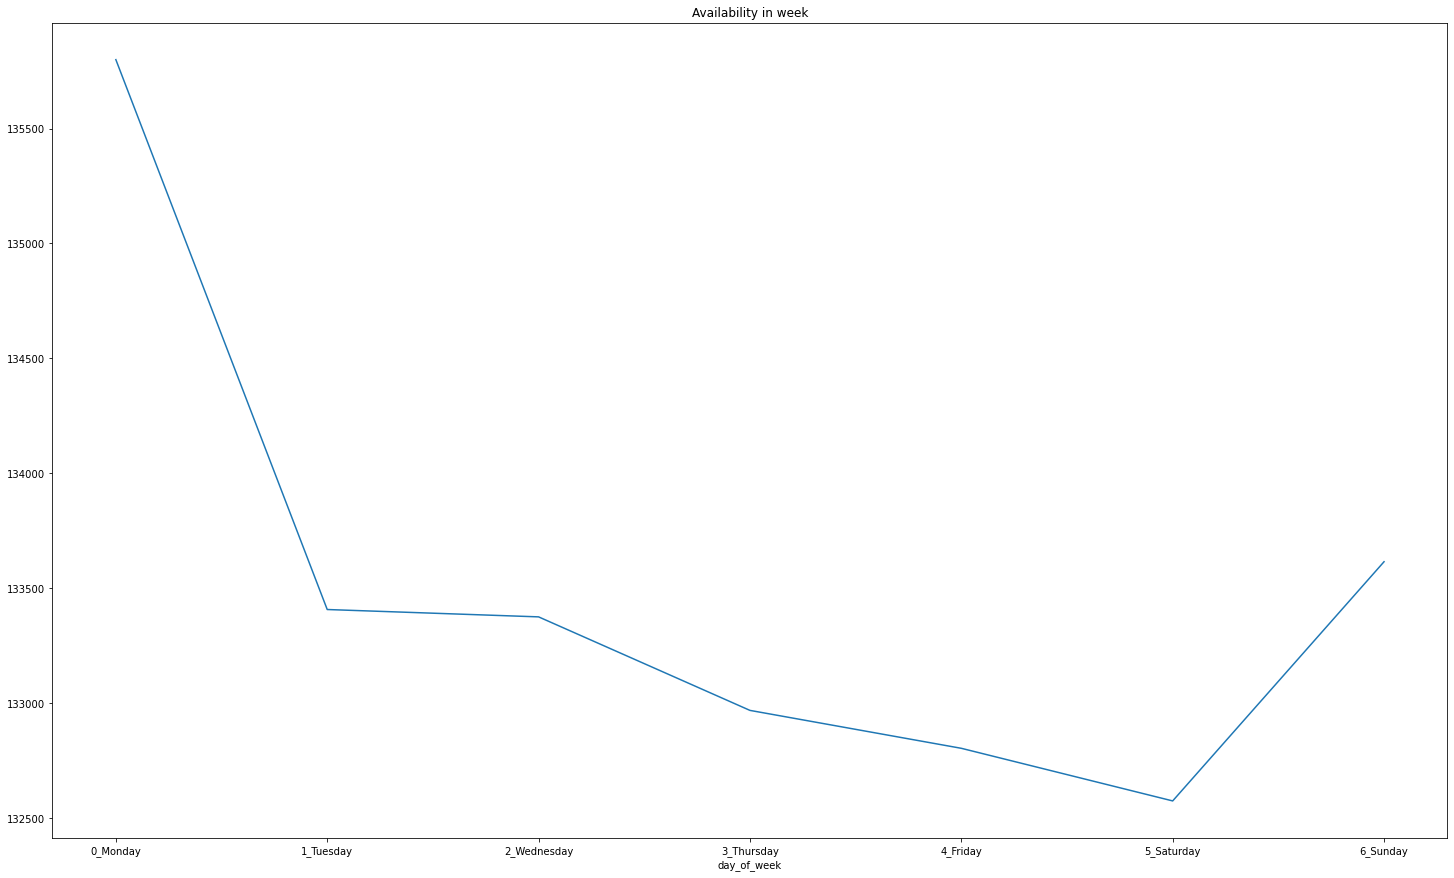

In [61]:
def convert_tf_to_number(s: str) -> int:
    if(s == 't'):
        return 1
    elif(s == 'f'):
        return 0
    else:
        raise InputException("Invalid input. Only 't' or 'f' is accepted.")
        
calendar_filled["available_number"] = calendar_filled.available.apply(convert_tf_to_number)
_ = calendar_filled.groupby("day_of_week")["available_number"].sum().plot.line(title="Availability in week", figsize=(25, 15))

We can see that the `price` is highest in Friday and Staturday. 
And it's reasonable when the `availability` is opposite to the `price`

What about the `price` through months?

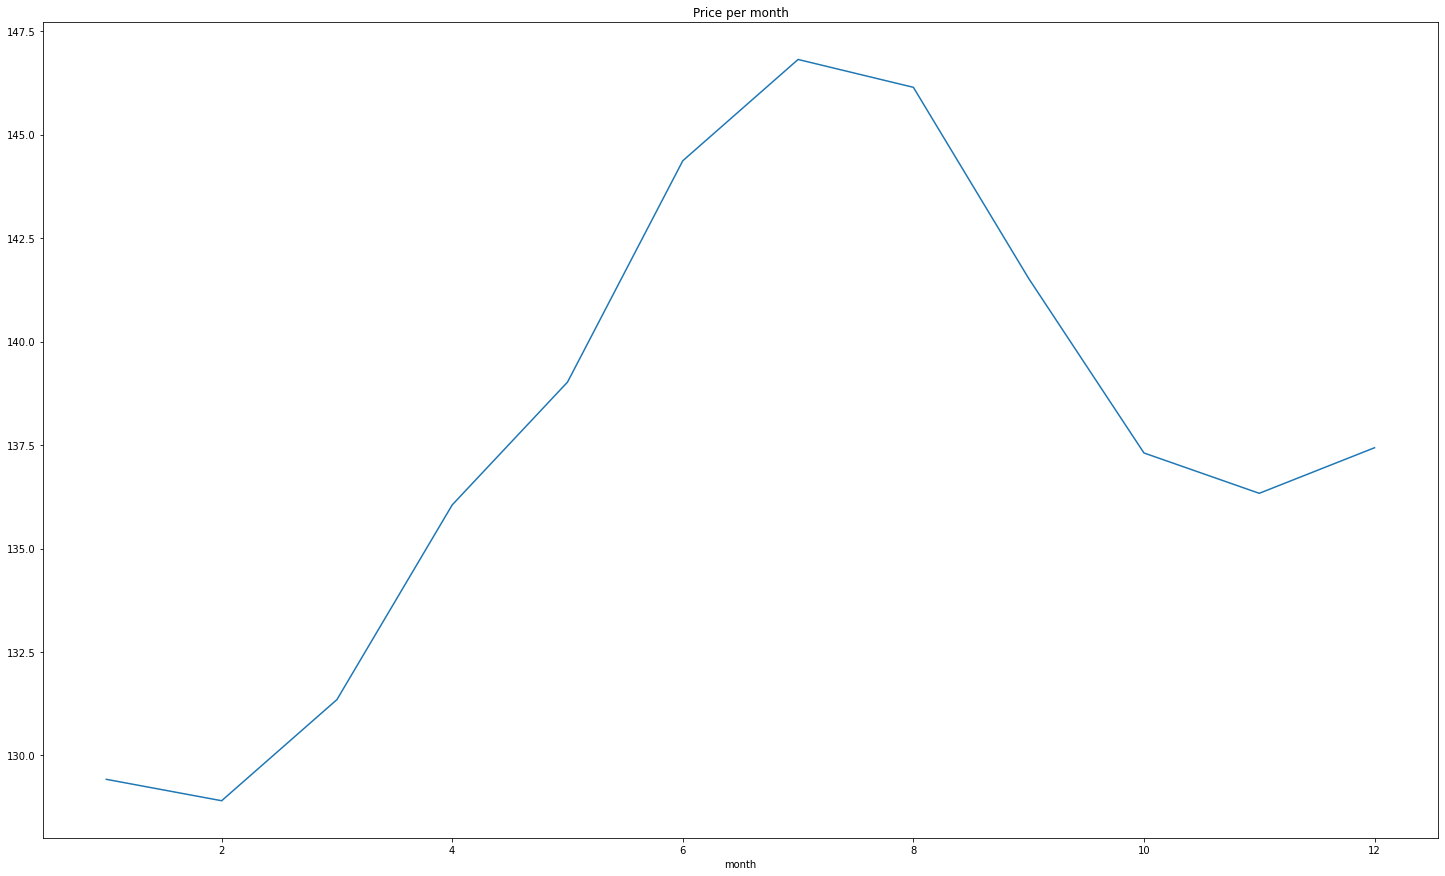

In [64]:
_ = calendar_filled.groupby("month")["price"].mean().plot.line(title="Price per month", figsize=(25, 15))

# The listing data

## Clean data

First look at the missing value

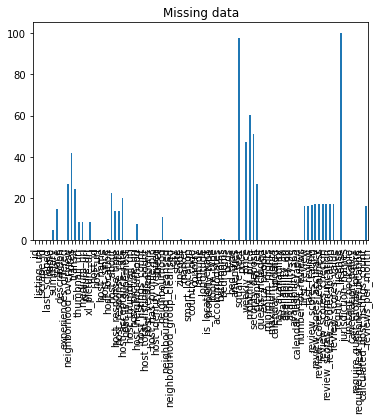

In [24]:
explore_missing_value(listings_df)

There are some columns that have more than **90%** missing value.
We should consider to drop them.

In [25]:
def get_missing_columns(df: DataFrame, missing_rate=.5) -> List[str]:
    """
    Get colums name that rate of missing value greater than `missing_rate`
    
    Params:
    df -- The dataframe
    missing -- The missing rate
    
    Returns
    List of columns name that has missing value more than missing rate
    """
    
    return set(df.columns[df.isna().mean() > missing_rate])

In [26]:
_90_missing_columns = get_missing_columns(listings_df, 0.9)
print(_90_missing_columns)

{'square_feet', 'license'}


There're 2 columns that has more than 90% missing and they look not important. Let's drop them all.

In [27]:
listing_dropped = listings_df.drop(_90_missing_columns, axis=1)

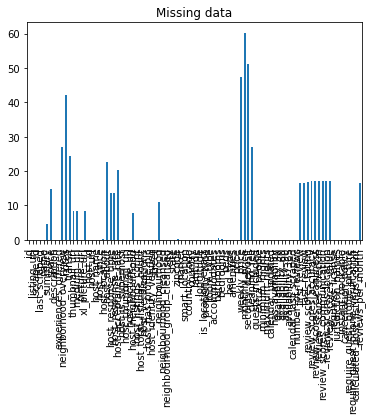

In [28]:
explore_missing_value(listing_dropped)

There're some varaibles that contains only one value. It's good to remove them.

In [29]:
def is_constant(column: Series) -> bool:
    """Check if a Series is contains only one value """
    return column.unique().shape[0] == 1

unique_value_columns = [column for column in listing_dropped.columns if is_constant(listing_dropped[column])]
print(unique_value_columns)

['scrape_id', 'last_scraped', 'experiences_offered', 'market', 'country_code', 'country', 'has_availability', 'calendar_last_scraped', 'requires_license', 'jurisdiction_names']


Let's drop these columns

In [30]:
listing_dropped = listing_dropped.drop(unique_value_columns, axis=1)

We should find columns that contains currency value, like the `price` of `calendar_df`

In [31]:
# Find object columns
object_data = listing_dropped.select_dtypes(include=["object"])
def is_currency(column: Series) -> bool:
    return column.str.match("[\$]").all()

# Find column name of currency columns
currency_columns = [ column for column in object_data.columns if (is_currency(object_data[column]))]

# Convert corrency column dtype to float
listing_converted = convert_currency_to_float(listing_dropped, *currency_columns)

Beside the `$` we also have `%` sign in the numerical columns that we should handle

In [32]:
def is_percent(column: Series) -> bool:
    return column.str.match(".+[%]$").all()
# Find column name of percent columns
percent_columns = [ column for column in object_data.columns if (is_percent(object_data[column]))]
listing_converted = convert_percent_to_float(listing_converted, *percent_columns)

Next, I'd like to fill numerical columns with `mean()`

In [33]:
numerical_columns = listing_converted.select_dtypes(exclude="object").columns
listing_filled = fill_na_mean(listing_converted, *numerical_columns)

There're still some variables that has large amount of missing value when compare to the rest(more than 4%).
Let's see what are they.

Some of them seem to be useless, so that I'd like to drop them.
The variables like `url` or `summary` or `id` need to be remove

In [34]:
drop_columns = list([
    'id',
    'space',
    'state',
    'name',
    'availability_365',
    'availability_90',
    'availability_60',
    'availability_30',
    'description',
    'listing_url',
    'thumbnail_url',
    'medium_url',
    'summary',
    'calendar_updated',
    'host_neighbourhood',
    'neighbourhood',
    'host_response_time',
    'host_since',
    'picture_url',
    'xl_picture_url',
    'host_url',
    'host_name',
    'host_thumbnail_url',
    'host_picture_url',
    'first_review',
    'neighborhood_overview',
    'notes',
    'transit',
    'host_about',
    'neighbourhood_cleansed',
    'last_review',
    'host_location',
    'host_verifications',
    'street',
    'host_is_superhost',
    'host_has_profile_pic',
    'host_identity_verified',
    'neighbourhood_group_cleansed',
    'city',
    'zipcode',
    'smart_location',
    'is_location_exact',
    'instant_bookable',
    'cancellation_policy',
    'require_guest_profile_picture',
    'require_guest_phone_verification',
    'host_id',
    'host_response_rate',
    'host_acceptance_rate'])
listing_filled = listing_filled.drop(drop_columns, axis=1)

## 2. Question 2. Which factor affecting the `price`

***The relationship between `price` and orthers***

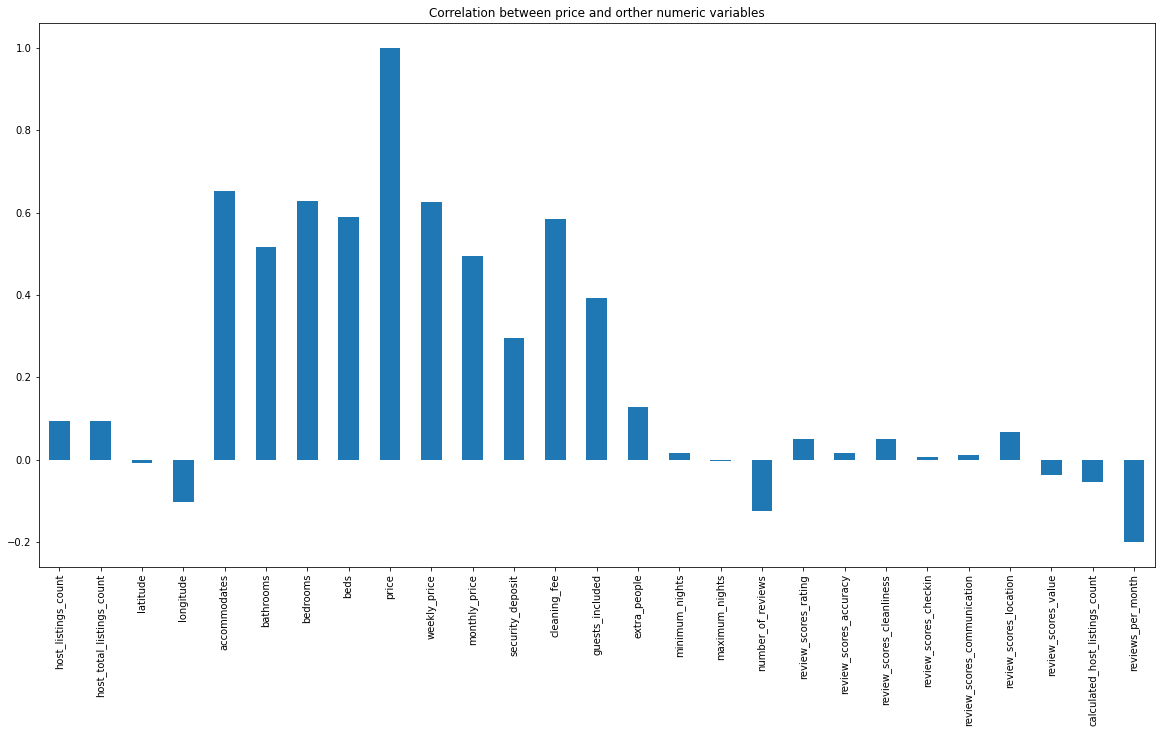

In [35]:
_ = listing_filled.corr().price.plot.bar(title="Correlation between price and orther numeric variables",figsize=(20,10))

There're some vairable that is important to decide the `price`: `accommodates`, `bathroms`, `bedrooms`, `beds`, `weekly price`, `monthly_price`,...

**Then we take a look at the relationship with *category variable***

In [36]:
catergory_vars = [
    'property_type',
    'room_type',
    'bed_type'
]

In [37]:
def get_dummies(df: DataFrame, *columns: List[str]) -> DataFrame:
    """Convert `columns` in `df` to dummy variables"""
    for column in columns:
        df = pd.concat([df.drop(column, axis=1), pd.get_dummies(df[column], drop_first=True, dummy_na=True, prefix=column, prefix_sep='_')], axis=1)
    
    return df


**With the `property_type`**

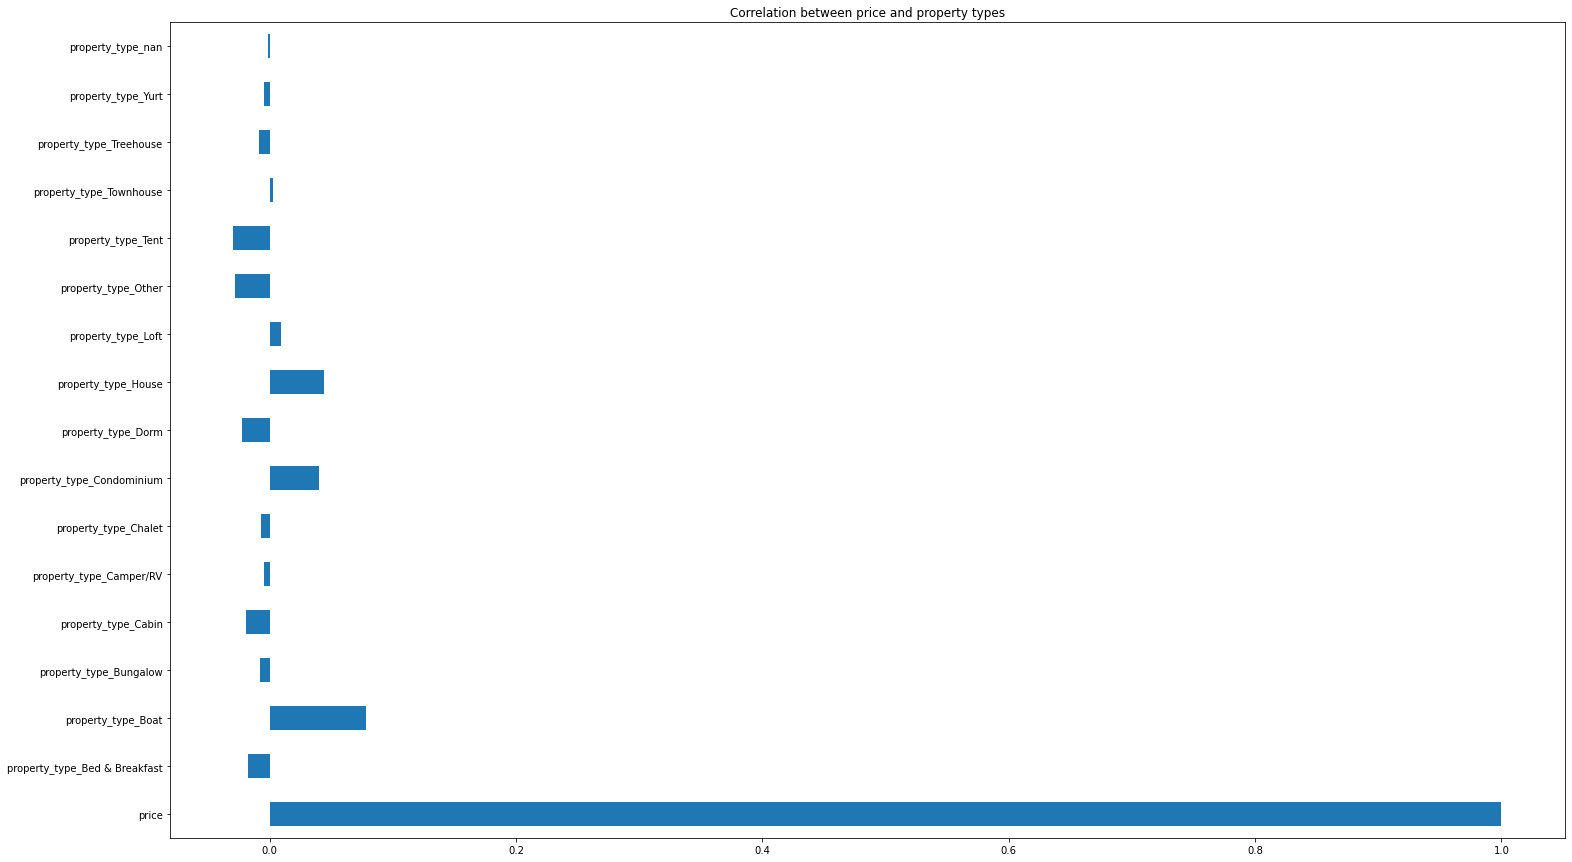

In [67]:
price_vs_property_type = get_dummies(listing_filled[["price", catergory_vars[0]]], catergory_vars[0])
_ = price_vs_property_type.corr().price.plot.barh(figsize=(25, 15), title="Correlation between price and property types")

**With the `room_type`**

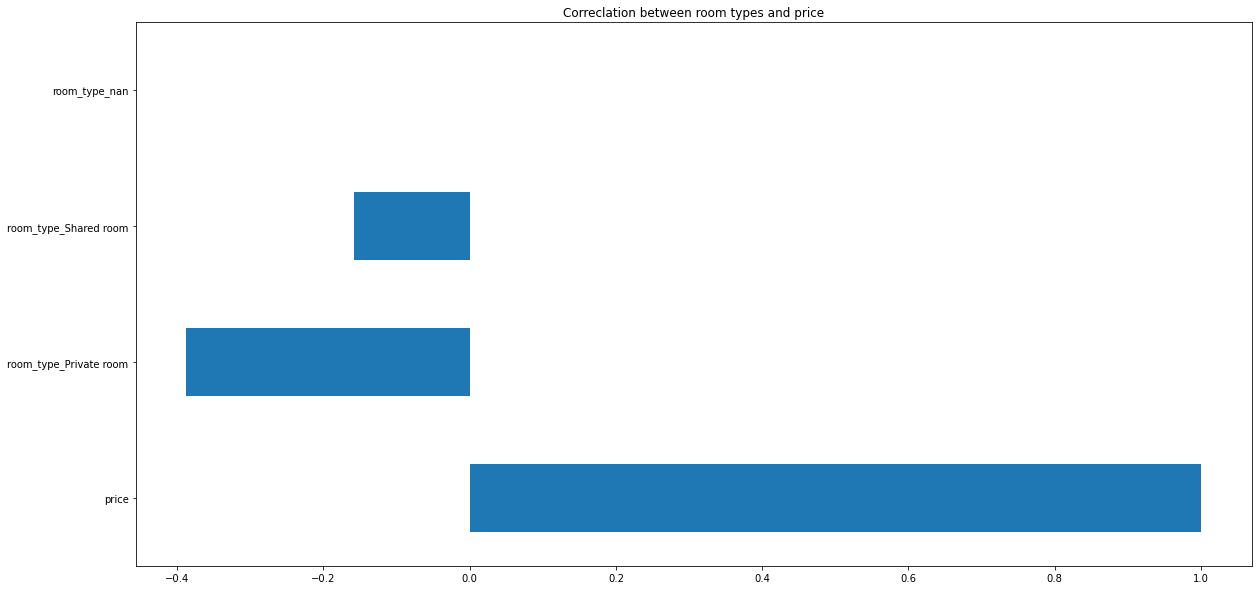

In [66]:
price_vs_room_type = get_dummies(listing_filled[["price", catergory_vars[1]]], catergory_vars[1])
_ = price_vs_room_type.corr().price.plot.barh(title="Correclation between room types and price", figsize=(20, 10))

**With the `bed_type`**

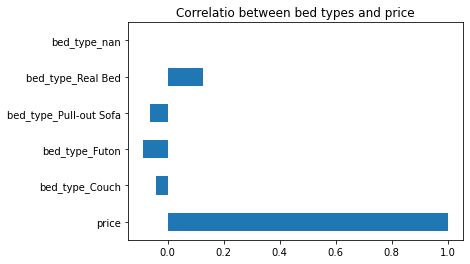

In [56]:
price_vs_bed_type = get_dummies(listing_filled[["price", catergory_vars[2]]], catergory_vars[2])
_ = price_vs_bed_type.corr().price.plot.barh(title="Correlatio between bed types and price")

## Handle `amenities`

In [41]:
ALL = []
for amenities in listing_filled.amenities:
    ALL += re.sub('[\{\}\"]', '', amenities).split(',')
    
ALL = pd.unique(ALL)

In [42]:
zero_matrix = np.zeros((len(listing_filled), len(ALL)))
dummies_ame = pd.DataFrame(zero_matrix, columns=ALL)

In [43]:
for i, amenities in enumerate(listing_filled.amenities):
    indices = dummies_ame.columns.get_indexer(amenities.replace('{','').replace('}','').replace('"','').split(','))
    dummies_ame.iloc[i,indices]=1

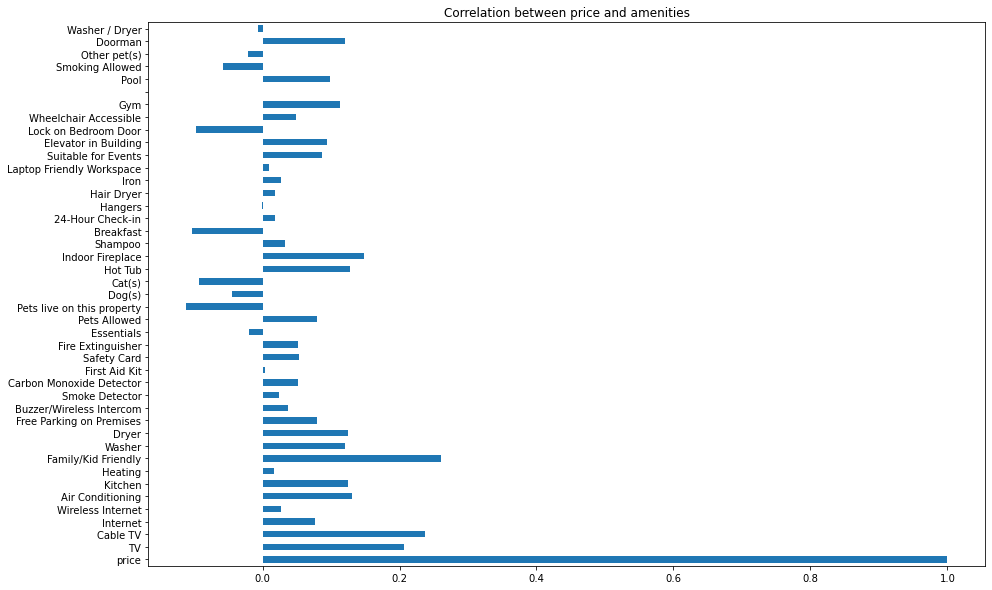

In [59]:
price_vs_amenities = pd.concat([listing_filled["price"], dummies_ame], axis=1)
corr = price_vs_amenities.corr().price
_ = corr.plot.barh(title="Correlation between price and amenities", figsize=(15, 10))

Here we have the correlation between `price` and for i, `amenities`. Let's filter the importance 
varaibles to see clearly!

## 3. Question 3 - Which state should we go to get the cheaper price?

First I want to use the original data and fill the price with mean

In [46]:
full_price_data = convert_currency_to_float(listings_df, 'price')
full_price_data = fill_na_mean(full_price_data, 'price')

Then, we go to extract the `host_state` from `host_location`

In [47]:
def parse_state(location: str) -> str:
    """Return state from location string"""
    if (not isinstance(location, str)):
        return ""
    
    parse_values = location.split(',')
    return parse_values[1].strip() if (len(parse_values) > 1) else ""

full_price_data["host_state"] = full_price_data["host_location"].apply(parse_state)

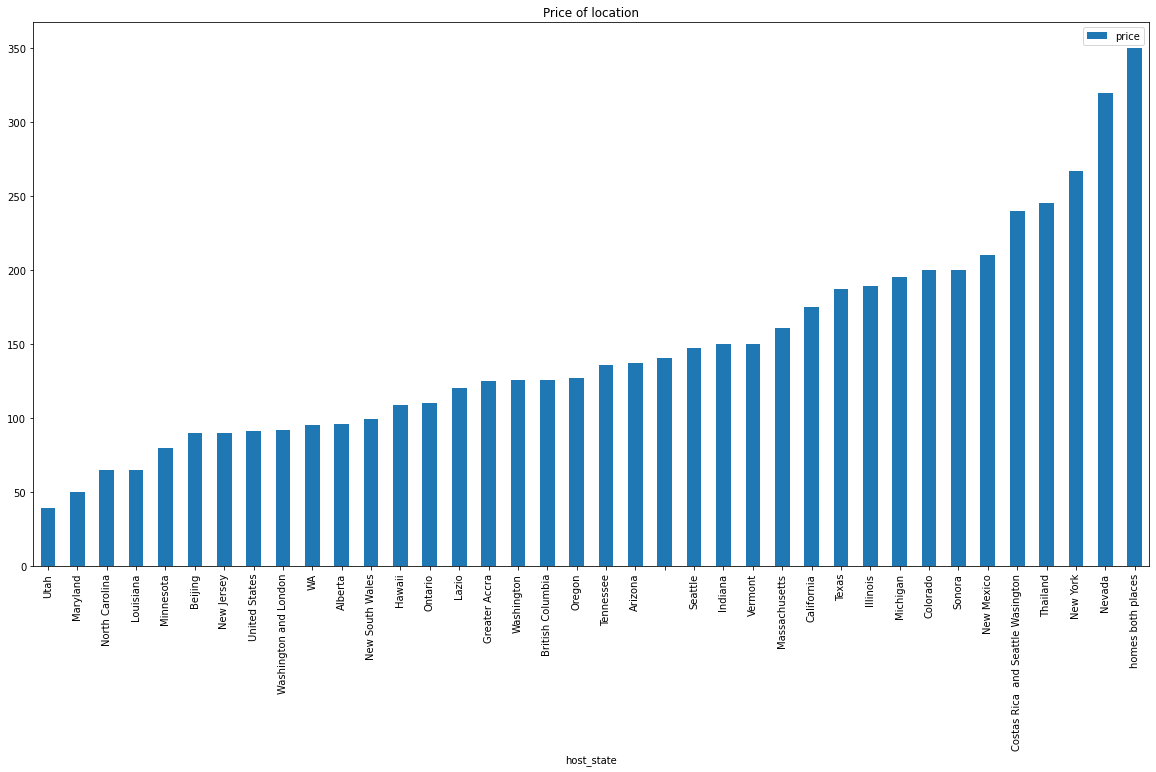

In [65]:
_ = full_price_data[["host_state", "price"]].groupby("host_state").mean().sort_values("price").plot.bar(title="Price of location",
                                                                                                        figsize=(20,10))

# Predict the price

I'd like to collect all data we just clean or generate:

In [49]:

listing_filled = listing_filled.drop("amenities", axis=1)
# dummies the category variables
ensemble_data = get_dummies(listing_filled, catergory_vars)

# combine to the dummies amenities
ensemble_data = pd.concat([ensemble_data, dummies_ame], axis=1)

In [50]:
def predict(df: DataFrame, label: str, rand_state=42, test_size=.3):
    """
    Make train, test set from df and label.
    Create the LinearRegression model (lm_model)
    fit lm_model and calculate the r2_score
    
    Param:
    df -- The dataframe
    label -- The label
    rand_state -- Random state for train_test_split
    test_size -- The size of test data
    
    Return 
    lm_model, r2_score
    """
    X = df.drop(label, axis=1)
    Y = df[label]
    
    X_train, X_test, y_train, y_test = train_test_split(X, Y,
                                                        random_state=rand_state,
                                                        test_size=test_size)
    
    lm_model = LinearRegression(normalize=True)
    lm_model.fit(X_train, y_train)
    
    pred = lm_model.predict(X_test)
    train_score = r2_score(y_train, lm_model.predict(X_train))
    pred_score = r2_score(y_test, pred)
    
    return lm_model, pred_score, train_score, X_train, X_test, y_train, y_test, pred

In [51]:
lm_model, pred_score, train_score, X_train, X_test, y_train, y_test, pred = predict(pd.concat([dummies_ame, listing_filled.price], axis=1), "price")

In [52]:
print(f"Score: {pred_score}")

Score: 0.17672303742829654
